In [4]:
from scipy import *
from scipy import ndimage
from PIL import Image, ImageDraw
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import os
import scipy.linalg 
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import cv2 as cv
from scipy.ndimage.interpolation import rotate
import skimage.exposure
from numpy import linalg as LA

In [5]:
fname='cw/test/masks/13.bmp'
blur_radius = 1.0
threshold = 50

img = Image.open(fname).convert('L')
img = np.asarray(img)

# smooth the image (to remove small objects)
imgf = ndimage.gaussian_filter(img, blur_radius)
threshold = 50

# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is {}".format(nr_objects))

#creating array of masks for each component
components = []
for k in range(nr_objects+1):
    single_component = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if labeled[i][j] == k:
                single_component[i][j] = 1
    components.append(single_component)

Number of objects is 25


In [6]:
#move component to the center 
def calc_weight_center(x, max_val, min_val):
            X = 1 - (np.array(x) - min_val) / (max_val - min_val)
            center = [0, 0]
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    center[0] += i * X[i][j]
                    center[1] += j * X[i][j]
            sum = int(np.round(np.sum(X)))
            center[0]=int(center[0]/sum)
            center[1]=int(center[1]/sum)
            return center 

def make_new_matrix(x, shift, default_vals):
    new_matrix = np.full(x.shape, default_vals)
    s = (int(shift[0]), int(shift[1]))
    for i in range(max(0, s[0]), min(x.shape[0], x.shape[0] + s[0])):
        for j in range(max(0, s[1]), min(x.shape[1], x.shape[1] + s[1])):
            new_matrix[i][j] = x[i - s[0]][j - s[1]]
    return new_matrix

In [7]:
# saving masks
for i in range(1, len(components)):
    test = (components[i]-1)*(-1) 
    max_val = np.max(test)
    min_val = np.min(test)
    weight_center = calc_weight_center(test, max_val, min_val)
    shift = np.array([test.shape[0] / 2, test.shape[1] / 2]) - weight_center
    test_img = make_new_matrix(test, shift, max_val)
    test_img = test_img*(-1)+1
    example = Image.fromarray(np.uint8(cm.gist_earth(test_img)*255))
    folder_name = 'dataset'
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    example.save(os.path.join(folder_name,'img_{}.bmp'.format(i)))

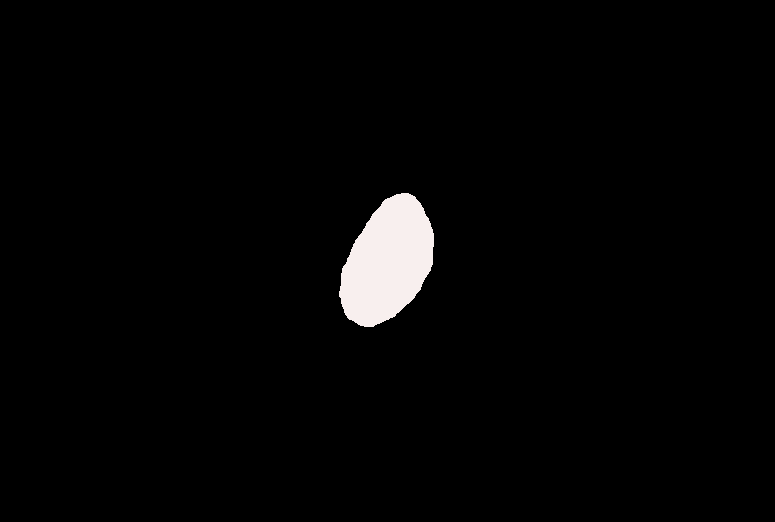

In [13]:
i = 7   #for example
im = cv.imread(os.path.join(folder_name,'img_{}.bmp'.format(i)))
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
Image.fromarray(np.uint8(cm.gist_earth(imgray)*255))

In [14]:
#Method to rotate a greyscale image based on its principal axis.

def verticalize_img(img):
    # Get the coordinates of the points of interest:
    X = np.array(np.where(img > 0)).T
    # Perform a PCA and compute the angle of the first principal axes
    pca = PCA(n_components=2).fit(X)
    theta = np.arctan2(*pca.components_[0])
    
    rotated_img = rotate(img,theta/pi*180-90, reshape=False)
    return rotated_img

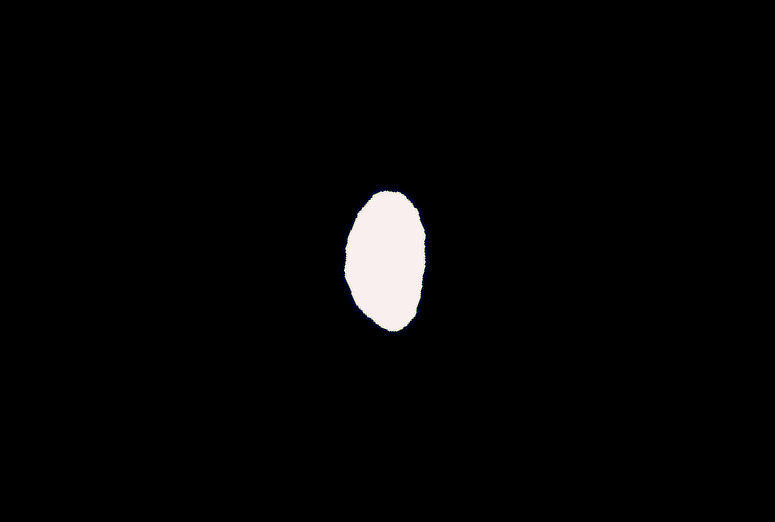

In [15]:
vertical = verticalize_img(imgray)
rotated_img_ = Image.fromarray(np.uint8(cm.gist_earth(vertical)*255))
rotated_img_

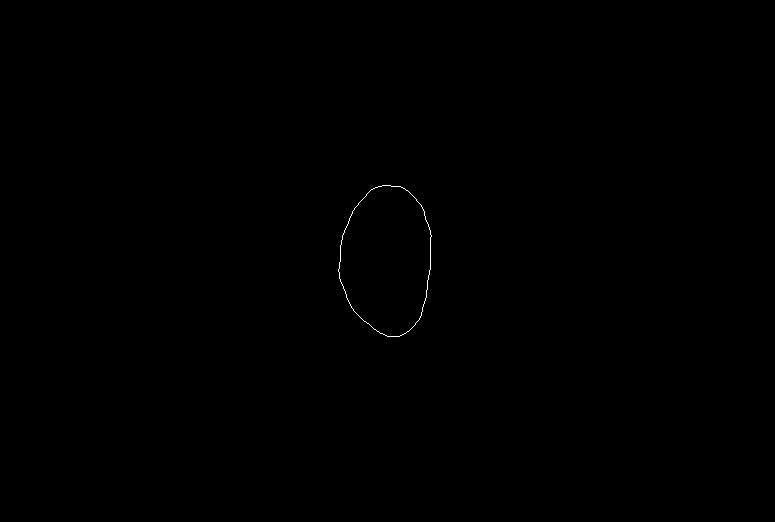

In [16]:
# blur threshold image to smooth the edges
blur = cv.GaussianBlur(vertical, (0,0), sigmaX=2, sigmaY=2, borderType = cv.BORDER_DEFAULT)

ret, thresh = cv.threshold(imgray, 0, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(blur, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)

img_array = []
img = np.full(im.shape[:2], 0)
for j in range(len(contours)):
    for i in contours[j]:
        img[i[0][1], i[0][0]] = 255
        img_array.append([i[0][1], i[0][0]])
img_ = Image.fromarray(np.uint8(cm.gist_earth(img)*255))
img_

In [17]:
link = folder_name
landmarks_array = []
#selected only not damaged cells
selected_ones = [4,5,6,7,9,10,11,12,13,14,15,17,18,19,22,23]
for k in selected_ones:
    img_array = []
    points = []
    landmarks = []
    im = cv.imread(os.path.join(link, 'img_{}.bmp'.format(k)))
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    vertical = verticalize_img(imgray)
    blur = cv.GaussianBlur(vertical, (0,0), sigmaX=2, sigmaY=2, borderType = cv.BORDER_DEFAULT)
    ret, thresh = cv.threshold(imgray, 0, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(blur, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
    #img = np.full(im.shape[:2], 0)
    for j in range(len(contours)):
        for i in contours[j]:
            #img[i[0][1], i[0][0]] = 255
            img_array.append([i[0][1], i[0][0]])
    for i in range(0, len(img_array), len(img_array)//57):
        landmarks.append(img_array[i])
        if len(landmarks) == 60:
            landmarks.append(img_array[len(img_array)-1])
            landmarks.append(img_array[1])
            landmarks.append(img_array[10])
            landmarks.append(img_array[20])
            break
    landmarks_array.append(landmarks)    

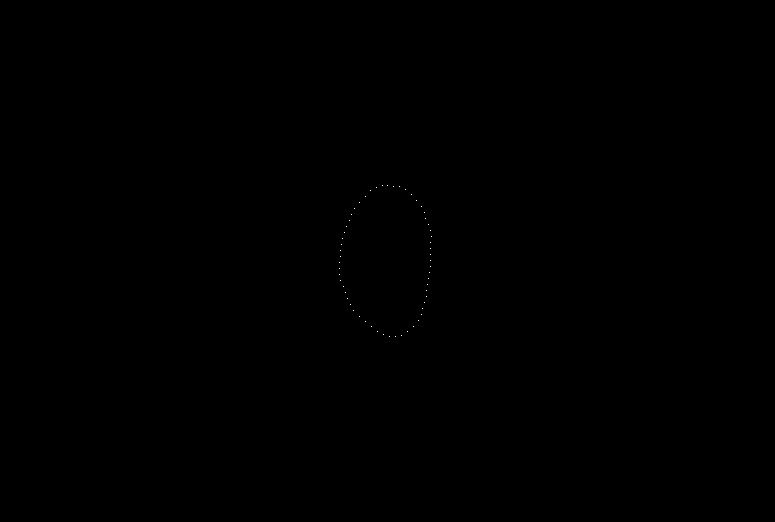

In [20]:
img_7 = np.full(imgray.shape, 0)
for i in landmarks_array[3]:
    img_7[i[0], i[1]] = 255
img_7_ = Image.fromarray(np.uint8(cm.gist_earth(img_7)*255))
img_7_

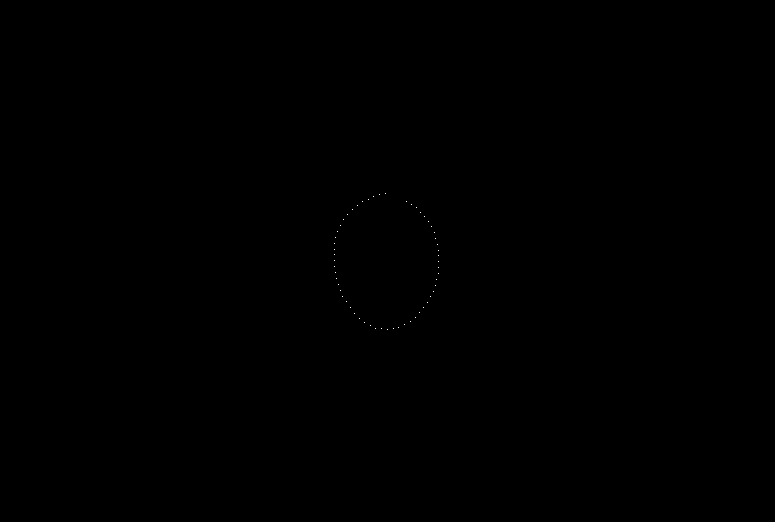

In [18]:
# mean shape
length = []
for i in range(len(landmarks_array)):
    length.append(len(landmarks_array[i]))

min_length = min(length)

res = np.array(landmarks_array[0][:min_length])
for i in range(1, len(selected_ones)):
    res += np.array(landmarks_array[i][:min_length])

res = res//len(selected_ones)

mean_img = np.full(imgray.shape, 0)
for i in res:
    mean_img[i[0], i[1]] = 255
mean_img = Image.fromarray(np.uint8(cm.gist_earth(mean_img)*255))
mean_img

In [11]:
# la = landmarks array
# separate cov matrix for x and y
la_x = []
la_y = []
for i in range(0, len(landmarks_array)):
    tmp = [landmarks_array[i][k][0] for k in range(min_length)]
    la_x.append(tmp)
    tmp = [landmarks_array[i][k][1] for k in range(min_length)]
    la_y.append(tmp)


In [12]:
mat_x = la_x[0]
mat_y = la_y[0]
for i in range(1, len(landmarks_array)):
    mat_x = np.vstack((mat_x, la_x[i]))
    mat_y = np.vstack((mat_y, la_y[i]))

In [13]:
cov_x = np.cov(mat_x.T)
cov_y = np.cov(mat_y.T)

In [14]:
wx, vx = LA.eig(cov_x)
wy, vy = LA.eig(cov_y)

In [15]:
# interval depends on eigenvalues ???

def coef_x():
    return random.uniform(-20, +20)

def coef_y():
    return random.uniform(-20, +20)

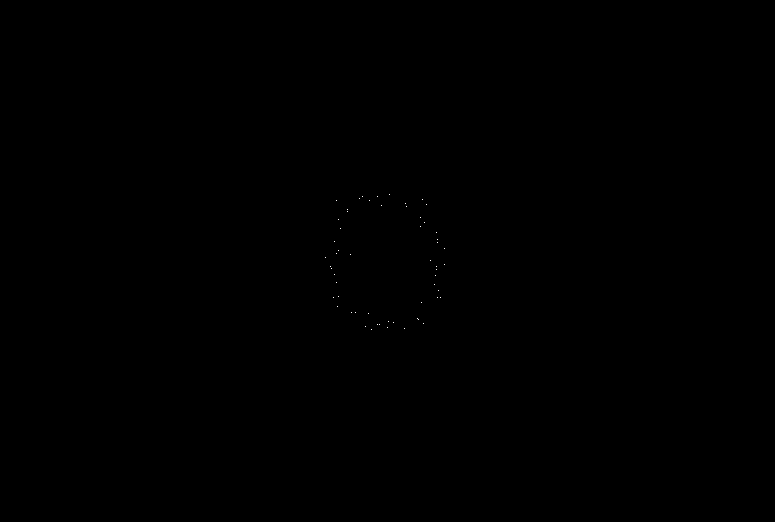

In [16]:
# следующие 5 ячеек делаются в один шаг в последней ячейке, но тут видно работу алгоритма по шагам

var_x = vx[0]*coef_x()
for i in range(1, len(selected_ones)):
    var_x += vx[i]*coef_x()

var_y = vy[0]*coef_y()
for i in range(1, len(selected_ones)):
    var_y += vy[i]*coef_y()
    
points = []
for i in range(len(var_x)):
    points.append([var_x[i].real, var_y[i].real])
    
res_ = res + points
new_img = np.full(imgray.shape, 0)
for i in res_:
    new_img[int(i[0]), int(i[1])] = 255
new_img_ = Image.fromarray(np.uint8(cm.gist_earth(new_img)*255))
new_img_

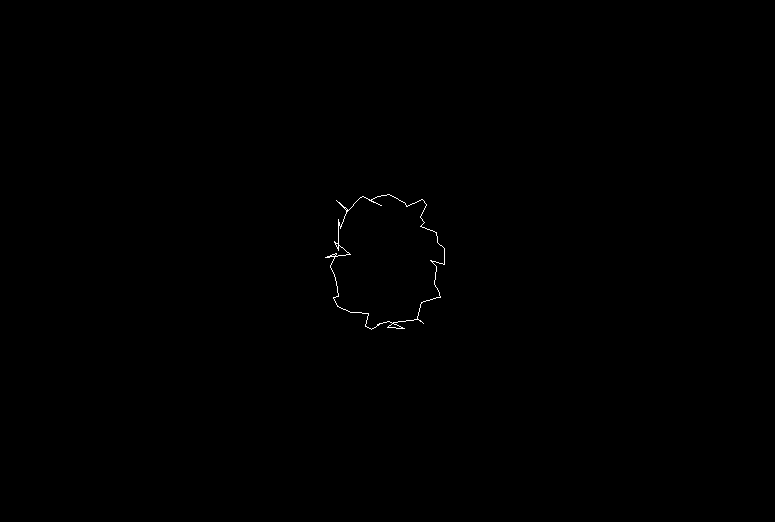

In [17]:
img2 = np.array(new_img, dtype=np.uint8)
for i in range(1, len(res_)):
    img = cv.line(img2, (int(res_[i-1][1]),int(res_[i-1][0])), (int(res_[i][1]),int(res_[i][0])), 255, 1)
img2 = cv.line(img2, (int(res_[len(res_)-1][1]),int(res_[len(res_)-1][0])), (int(res_[0][1]),int(res_[0][0])), 255, 1)
img_ = Image.fromarray(np.uint8(cm.gist_earth(img2)*255))
img_

The longest contour is: 0
2


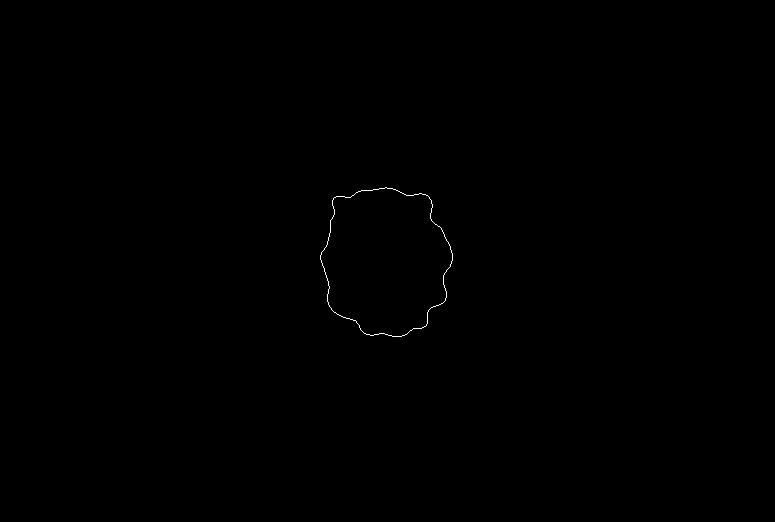

In [18]:
blur = cv.GaussianBlur(img2, (0,0), sigmaX=5, sigmaY=5, borderType = cv.BORDER_DEFAULT)

ret, thresh = cv.threshold(blur, 5, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)

img_array = []
img = np.full(img.shape[:2], 0)
max_con = 0
max_i = -1
for i in range(len(contours)):
    if len(contours[i]) > max_con:
        max_con = len(contours[i])
        max_i = i
print("The longest contour is:", max_i)

for i in contours[max_i]:
    img[i[0][1], i[0][0]] = 255
    img_array.append([i[0][1], i[0][0]])
print(len(contours))
img_ = Image.fromarray(np.uint8(cm.gist_earth(img)*255))
img_


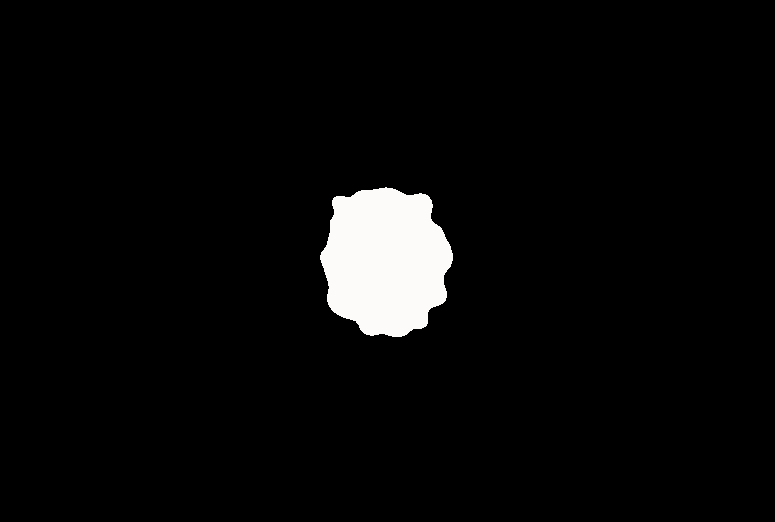

In [19]:
img3 = cv.fillPoly(img, pts =[contours[max_i]], color=255)
img3_ = Image.fromarray(np.uint8(cm.gist_earth(img3)*255))
img3_

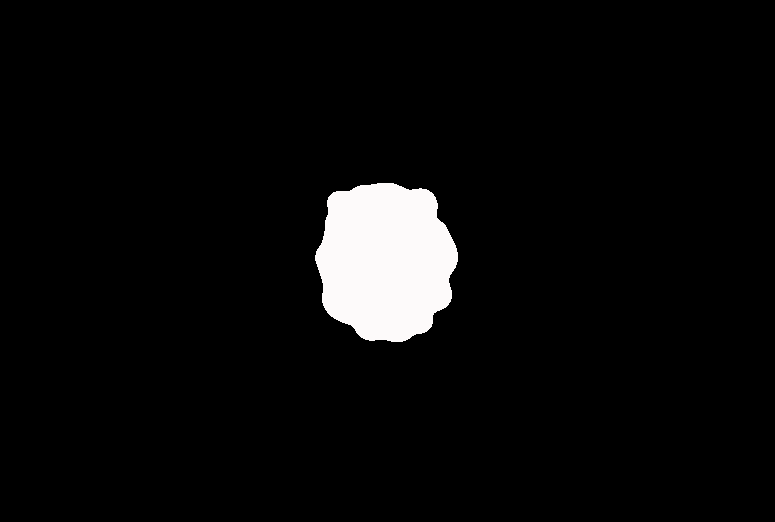

In [20]:
# a little smooth
img3 = np.array(img3, dtype=np.uint8)
blur = cv.GaussianBlur(img3, (0,0), sigmaX=3, sigmaY=3, borderType = cv.BORDER_DEFAULT)
ret, thresh = cv.threshold(blur, 10, 255, cv.THRESH_BINARY)
img4_ = Image.fromarray(np.uint8(cm.gist_earth(thresh)*255))
img4_


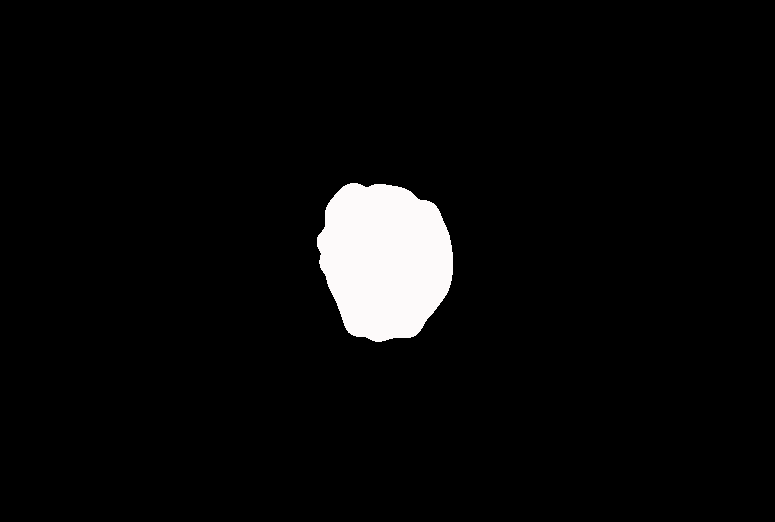

In [21]:
var_x = vx[0]*coef_x()
for i in range(1, len(selected_ones)):
    var_x += vx[i]*coef_x()

var_y = vy[0]*coef_y()
for i in range(1, len(selected_ones)):
    var_y += vy[i]*coef_y()
    
points = []
for i in range(len(var_x)):
    points.append([var_x[i].real, var_y[i].real])
    
res_ = res + points
new_img = np.full(imgray.shape, 0)
for i in res_:
    new_img[int(i[0]), int(i[1])] = 255

    
img2 = np.array(new_img, dtype=np.uint8)
for i in range(1, len(res_)):
    img = cv.line(img2, (int(res_[i-1][1]),int(res_[i-1][0])), (int(res_[i][1]),int(res_[i][0])), 255, 1)
img2 = cv.line(img2, (int(res_[len(res_)-1][1]),int(res_[len(res_)-1][0])), (int(res_[0][1]),int(res_[0][0])), 255, 1)


blur = cv.GaussianBlur(img2, (0,0), sigmaX=5, sigmaY=5, borderType = cv.BORDER_DEFAULT)

ret, thresh = cv.threshold(blur, 5, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(thresh, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)

img_array = []
img = np.full(img.shape[:2], 0)
max_con = 0
max_i = -1
for i in range(len(contours)):
    if len(contours[i]) > max_con:
        max_con = len(contours[i])
        max_i = i


for i in contours[max_i]:
    img[i[0][1], i[0][0]] = 255
    img_array.append([i[0][1], i[0][0]])
    
    
img3 = cv.fillPoly(img, pts =[contours[max_i]], color=255)
img3 = np.array(img3, dtype=np.uint8)
blur = cv.GaussianBlur(img3, (0,0), sigmaX=3, sigmaY=3, borderType = cv.BORDER_DEFAULT)
ret, thresh = cv.threshold(blur, 10, 255, cv.THRESH_BINARY)
img4_ = Image.fromarray(np.uint8(cm.gist_earth(thresh)*255))
img4_